In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# specify network parameters
datasize = 'full'
location = 'stavanger'
data_date = "['202204', '202208']"
# specify evaluation data parameters
eval_date = '202208'

# load network from pickle
model = data_date+'_waypoints_DP30_HDBSCAN30_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': "['../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_3.parquet', '../../data/processed/202208_points_stavanger_cleaned_meta_full_dualSplit_3.parquet']",
 'DP_tolerance': 30,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 30,
 'clustering_min_cluster_size': 30,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'merge_stops_speed': 2}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_3'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = network.crs  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 1192 (8 isolated)
Number of edges: 6019
------------------------


Evaluating graph on 19812 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 942.19 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.009489  0.009489   0.009489          0.009489  0.009489         0.009489
no_intersects  0.043105  0.000000   0.000000          0.043105  0.000000         0.000000
no_path        0.030991  0.000000   0.000000          0.030991  0.000000         0.000000
success        0.916414  0.916414   0.916414          0.916414  0.916414         0.916414

 --------------------------- 

Fraction of NaN results: 0.074

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.908 

Mean distance      = 308.74 m
Median distance    = 82.55 m
Standard deviation = 829.99 m 



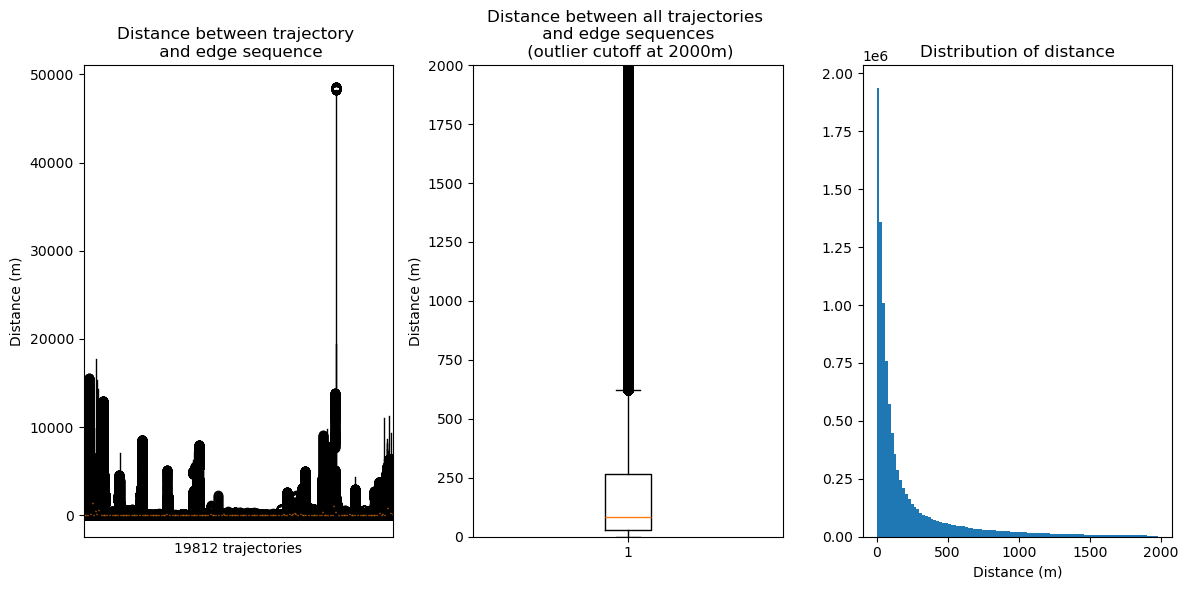

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [7]:
all_evaluation_results

,mmsi,SSPD,distances,fraction_covered,message,path,path_linestring
0,209275000_0_2022-08-18 01:35:48,392.819189,"[440.51998101626845, 441.24380418080773, 440.8...",1.000000,success,"[35, 88, 106, 850, 911, 910, 932, 985, 1168, 1...",LINESTRING (286515.47451757046 6484475.8230946...
0,209275000_1_2022-08-18 17:14:24,79.520186,"[18.504929666020978, 8.41402582854091, 9.51531...",0.329921,success,"[1138, 1137, 1110, 1109, 1101, 983, 1070, 1071...",LINESTRING (302645.3242267128 6537362.55340009...
0,209275000_2_2022-08-26 03:10:00,560.365373,"[627.5241813536782, 629.3383304504187, 634.286...",0.984763,success,"[89, 35, 88, 106, 850, 911, 910, 932, 1168, 11...",LINESTRING (286873.964800024 6483515.723540519...
0,209275000_3_2022-08-26 16:34:40,45.572393,"[127.50088077242465, 115.87945791803931, 105.7...",0.343597,success,"[1117, 1138, 1137, 1109, 983, 1071, 991, 872]",LINESTRING (303183.75404290186 6536829.2941162...
0,209332000_0_2022-08-31 12:17:09,31.245886,"[35.2808673934455, 35.012029763393876, 36.8347...",0.240961,success,"[44, 289, 288]",LINESTRING (324531.5431981397 6477584.63820709...
...,...,...,...,...,...,...,...
0,636092705_0_2022-08-15 04:32:20,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,636092705_0_2022-08-17 18:37:40,217.089471,"[41.299437917156304, 57.91569932626809, 75.994...",0.706082,success,"[1175, 1022, 1082, 1081, 1117, 1138, 1031, 103...",LINESTRING (303298.9221931999 6536637.03284414...
0,636092991_0_2022-08-12 18:09:08,52.351256,"[42.910374957924574, 35.57719660742839, 38.649...",0.599415,success,"[903, 902, 898, 897, 929, 963, 1024, 1085, 108...",LINESTRING (283916.6932513973 6551146.03507942...
0,636092991_1_2022-08-15 05:45:20,NaN,NaN,0.000000,no_intersects,NaN,NaN


In [8]:
df = all_evaluation_results

In [9]:
# Filter out NaN results and bad examples
nan_mask = df.isna().any(axis=1)
df = df[~nan_mask]
#df = df[df['fraction_covered']>0.8]
#df = df[df['SSPD']<300]

In [10]:
# merge results with trajectory data and metadata
test_trajectories = test_trajectories.filter('mmsi', df['mmsi'].tolist())
traj_gdf = test_trajectories.to_traj_gdf()
merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe']
test_gdf.drop_duplicates(subset=['mmsi'], inplace=True)
test_gdf.rename(columns={'length': 'lengde'}, inplace=True)
traj_gdf = traj_gdf.merge(test_gdf[merge_columns], on='mmsi', how='left')

merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe', 'geometry']
df = df.merge(traj_gdf[merge_columns], on='mmsi', how='left')
df = gpd.GeoDataFrame(df)

In [11]:
df.to_csv(model+'_'+eval_date+'_paths.csv')

In [12]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18344 entries, 0 to 18343
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   mmsi              18344 non-null  object  
 1   SSPD              18344 non-null  float64 
 2   distances         18344 non-null  object  
 3   fraction_covered  18344 non-null  float64 
 4   message           18344 non-null  object  
 5   path              18344 non-null  object  
 6   path_linestring   18344 non-null  object  
 7   lengde            18344 non-null  object  
 8   bredde            15974 non-null  float64 
 9   dypgaaende        13673 non-null  float64 
 10  skipstype         15977 non-null  object  
 11  skipsgruppe       15977 non-null  object  
 12  geometry          18344 non-null  geometry
dtypes: float64(4), geometry(1), object(8)
memory usage: 1.8+ MB
